# DATA EDA 분석 
### 1_1. (2020.11.28(Sat.)) <br>1_2. (2020.12.03(Thu.))

* 라이브러리 불러오기

##### 우혜민 1-2) library import 시 warning message를 띄우지 않기 위해서 해당 코드 추가, 필요한 시각화 library 추가

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
!pip install plotnine

     |████████████████████████████████| 4.4 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 20.7 MB/s eta 0:00:01


In [5]:
# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# !pip install plotnine 이걸로 안되면 밑에 있는 코드로 라이브러리 설치
# !conda install -c conda-forge --yes plotnine
from plotnine import *

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.utils import plot_model

 * 데이터 불러오기

In [7]:
cks_dtype = {'clnt_id':'int64',
             'sess_id':'int64',
             'hit_seq':'int64',
             'action_type':'int64',
             'biz_unit':'category',
             'sess_dt':'object',
             'hit_tm':'object',
             'hit_pss_tm':'int64',
             'trans_id':'float64',
             'sech_kwd':'object',
             'tot_pag_view_ct':'float64',
             'tot_sess_hr_v':'float64',
             'trfc_src':'category',
             'dvc_ctg_nm':'category',
             'pd_c':'float64',
             'de_dt':'object',
             'de_tm':'object',
             'buy_am':'int64',
             'buy_ct':'int64',
             'clnt_gender':'category',
             'clnt_age':'float64'}

In [8]:
raw_data1_Online_Act = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
raw_data2_Trade_Inform = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
raw_data3_Demog = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
raw_data4_Item_Class = pd.read_csv('./DATA/item_add_nm0.csv', dtype=cks_dtype)

<br><br><br>
##### 우혜민 1-1) dtype설정 필요
현재 데이터 load를 하시면 memory error가 발생할텐데, 이는 dtype이 설정되어있지 않기 때문입니다. 따라서 테이블들의 관계를 고려하여 데이터 타입 설정을 권장드립니다.

<br><br><br>

## 1. 온라인 행동 데이터 확인

In [6]:
raw_data1_Online_Act.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,7809,1,8,5,A03,20190913,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN
1,7809,1,4,2,A03,20190913,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN
2,7809,1,11,5,A03,20190913,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN
3,7809,1,1,2,A03,20190913,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN
4,7809,1,9,5,A03,20190913,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN


* 1-1. clnt_id : 고객 고유 식별 ID
* 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID
* 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호
* 1-4. action_type : 온라인 행동 유형
 (0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 / 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션)
* 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드
* 1-6. sess_dt : 세션 일자(년월일)
* 1-7. hit_tm : 조회 시각(HH:MM)
* 1-8. hit_pss_tm : 조회 경과시간(세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정)
* 1-9. Trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
* 1-10. sech_kwd : 고객이 검색한 키워드
* 1-11. tot_pag_view_ct : 총 페이지 조회 건수(세션 내에 총 페이지(화면) 뷰 수)
* 1-12. tot_sess_hr_v : 총 세션 시간 값
* 1-13. trfc_src : 유입 채널
 (DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown)
* 1-14. dvc_ctg_nm : 기기 유형 (mobile_web / mobile_app / PC)

In [7]:
raw_data1_Online_Act.shape

(3196362, 14)

 * 행 수(데이터 갯수) : 319만 개
 * 열 수(데이터 종류) : 14개

### 1-1. clnt_Id : 고객 고유 식별 ID

 * 2-1, 3-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [8]:
raw_data1_Online_Act['clnt_id'].nunique()

72399

 * 고객ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 6600건, 최소 1건

In [9]:
raw_data1_Online_Act['clnt_id'].value_counts()

61252    6663
57915    5317
48181    4867
62445    4709
49906    4131
         ... 
22838       1
24306       1
26928       1
64305       1
49714       1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [10]:
raw_data1_Online_Act['clnt_id'].isna().sum()

0

### 1-2. sess_id : 세션이 시작될 때 부여되는 순번ID

 * 세션 ID는 몇 개나 있는가?? => 550개
 
     * 고객ID 7만명에 대한 온라인 행동이 있는데, 세션은 550개 밖에 안된다??
         * 세션ID에 결측치 많을 것을 예상 => 결측치 없음(아래 참조)
         * 같은 세션ID에 서로다른 고객ID 존재 예상

In [11]:
raw_data1_Online_Act['sess_id'].nunique()

550

 * 세션ID 별로 온라인 행동 데이터는 몇 건이 있는지? => 최대 51만 건, 최소 1건

In [12]:
raw_data1_Online_Act['sess_id'].value_counts()

1      517024
2      279811
3      203178
4      155479
5      130391
        ...  
527         1
516         1
524         1
518         1
514         1
Name: sess_id, Length: 550, dtype: int64

 * 결측치 갯수 확인 => 없음

In [13]:
raw_data1_Online_Act['sess_id'].isna().sum()

0

 * 같은 세선ID(=1) 내에 서로 다른 고객 ID 있는지 확인
     * 세션ID == 1 에서만 약 7만개의 고객 ID가 있음
     * 서로 다른 고객에게 유일하게 세션ID 부여되지 않는 다는 사실을 알게됨
     * 세션ID가 정확히 어떤 기준으로 부여되는지 추가 확인이 필요함

In [14]:
sess_is_1 = raw_data1_Online_Act['clnt_id'][raw_data1_Online_Act['sess_id']==1]

In [15]:
sess_is_1.head()

0    7809
1    7809
2    7809
3    7809
4    7809
Name: clnt_id, dtype: int64

In [16]:
sess_is_1.nunique()

72399

### 1-3. hit_seq : 조회 순서를 알 수 있도록 한 일련번호

 * 조회 일련번호는 몇 개나 있는가?? => 357개
 
     * 조회 일련번호가 다르면, 조회 상품이 다른가? => 추후 확인할 것

In [17]:
raw_data1_Online_Act['hit_seq'].nunique()

357

 * 조회일련번호 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 36만 건 , 최소 1건

In [18]:
raw_data1_Online_Act['hit_seq'].value_counts()

1      367149
2      246633
3      198580
4      167819
5      143873
        ...  
282         1
281         1
280         1
279         1
357         1
Name: hit_seq, Length: 357, dtype: int64

 * 결측치 갯수 확인 => 없음

In [19]:
raw_data1_Online_Act['hit_seq'].isna().sum()

0

<br><br><br>
##### 우혜민 1-1) sess_id : clnt의 로그인으로 발생한 세션을 구분하는 ID, hit_seq : 동일 sess_id 내에서 행동을 구분하는 id
상기 EDA 결과를 바탕으로 sess_id, hit_seq를 살펴보았습니다.

- sess_dt가 변화하는 경우 sess_id가 함께 바뀜
- sess_dt가 같은 경우에는 hit_tm이 변화해도 sess_id는 그대로 유지됨
- hit_tm이 변화하면 hit_seq가 변화함
- hit_pss_tm로 미루어보아 행동 순서에 따라 hit_seq가 생성됨

따라서 clnt가 꽤 긴 시간텀을 두고 쇼핑을 시작하는 경우 새로운 sess_id가 부여되며, 특정 sess_id 내에서 hit_seq를 통해 순차적인 행동을 구분할 수 있는 것으로 보입니다.
#####  clnt_id, sess_id, hit_seq가 Online_Act table의 Primary key column입니다.

In [20]:
raw_data1_Online_Act.loc[raw_data1_Online_Act['clnt_id']==30605, 
                         ['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'sess_dt', 'hit_tm', 'hit_pss_tm']].sort_values(by=['sess_id', 'hit_seq'])[:30]

,clnt_id,sess_id,hit_seq,action_type,sess_dt,hit_tm,hit_pss_tm
56,30605,1,1,1,20190712,22:53,186078
54,30605,1,2,2,20190712,22:53,187210
46,30605,2,1,1,20190717,17:25,92373
83,30605,2,2,1,20190717,17:25,92526
55,30605,2,3,2,20190717,17:25,93746
42,30605,2,4,3,20190717,17:25,102794
92,30605,2,5,5,20190717,17:25,105745
77,30605,2,6,4,20190717,17:25,110902
59,30605,2,7,5,20190717,17:25,111604
49,30605,2,8,4,20190717,17:25,114763


상단 테이블에 대한 scatterplot 코드를 만들어봤습니다. 그래프를 통해서 날짜가 변하면 sess_dt(y축 10의자리)가 함께 바뀌고 hit_seq(y축 1의자리)는 차례로 증가하는 것을 확인하실 수 있습니다.

추가적 EDA를 진행하실 때 도움이 되기를 바랍니다. 

(18087.0, 18109.0)

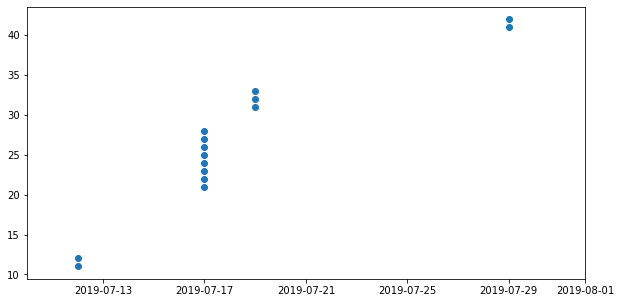

In [21]:
from datetime import datetime, date # 날짜형 자료형을 다루는 라이브러리
temp = raw_data1_Online_Act[(raw_data1_Online_Act['clnt_id']==30605) & (raw_data1_Online_Act['sess_id']<5)].copy() 
    # sess_id*10+hit_seq 계산을 위해 hit_seq<10인 sess_id만 고려함. 
temp.sess_dt = pd.to_datetime(temp.sess_dt, format='%Y%m%d') # sess_dt col의 자료형 변경

plt.figure(figsize=(10, 5)) # plot size 조절
plt.scatter(temp.sess_dt, temp.sess_id * 10 + temp.hit_seq) # scatter plot 작성 / sess_id, hit_seq range에 맞는 y축 연산 필요함.
plt.xlim([date(2019,7,10), date(2019,8,1)]) # x축 조정

<추가적인 분석 제안>

2020-11-27 23:59 ~ 2020-11-28 00:30 쇼핑을 하는 경우에는 sess_id, hit_seq가 어떤 방식으로 생성되는지 확인이 필요해 보입니다.

<br><br><br>

### 1-4. action_type : 온라인 행동 유형
 *  0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 
 * 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션

 * 온라인 행동 유형는 몇 개나 있는가?? => 8개
 
     * class 갯수는 9개이므로 존재하지 않는 행동 하나 있음
         * '8. 결재 옵션'은 데이터 존재하지 않음(하단 확인)

In [22]:
np.sort(raw_data1_Online_Act['action_type'].unique())

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

 * 온라인 행동 유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 75만 건 , 최소 5600건
     * 제일 많은 행동은 약 75만 건의 '5. 결제 시도' 이며
     * 제일 적은 행동은 약 5600건의 '7. 구매 환불' 임
     * '8. 결재 옵션'은 데이터 존제하지 않음이 확인됨

In [23]:
raw_data1_Online_Act['action_type'].value_counts()

5    750530
2    655266
0    651638
3    596765
1    307998
4    172240
6     56249
7      5676
Name: action_type, dtype: int64

 * 결측치 갯수 확인 => 없음

In [24]:
raw_data1_Online_Act['action_type'].isna().sum()

0

### 1-5. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 업종단위는 몇 개나 있는가?? => 3개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [25]:
raw_data1_Online_Act['biz_unit'].nunique()

3

 * 업종단위 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 23만 건 , 최소 19만건

In [26]:
raw_data1_Online_Act['biz_unit'].value_counts()

A03    2331437
A02     668093
A01     196832
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [27]:
raw_data1_Online_Act['biz_unit'].isna().sum()

0

### 1-6. sess_dt : 세션 일자(년월일)

 * 세션 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것을 예상됨
         * 7,8,9월 일자 = 31 + 31 + 30 = 92

In [28]:
raw_data1_Online_Act['sess_dt'].nunique()

92

 * 세션 일자 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 5.2만 건 , 최소 1.1만건
     * 월별로 데이터 몇 개인지 확인해보기 => 추후 수행

In [29]:
raw_data1_Online_Act['sess_dt'].value_counts()

20190708    52860
20190703    47333
20190729    46363
20190905    44881
20190918    43647
            ...  
20190811    24115
20190831    23355
20190915    23261
20190912    19337
20190913    11880
Name: sess_dt, Length: 92, dtype: int64

 * 결측치 갯수 확인 => 없음

In [30]:
raw_data1_Online_Act['sess_dt'].isna().sum()

0

<br><br><br>
##### 우혜민 1-1) 날짜 데이터 Preprocessing 중 대표적인 예시는 요일을 사용하는 것 입니다. 현재 weekday를 사용하여 요일 col(day)를 생성했습니다.

<추가적인 분석 제안>
주말/평일을 구분하는 것도 좋은 전처리 방법 중 하나입니다.

In [31]:
raw_data1_Online_Act.sess_dt = pd.to_datetime(raw_data1_Online_Act.sess_dt, format='%Y%m%d') # sess_dt col의 자료형 변경
raw_data1_Online_Act['day'] = raw_data1_Online_Act['sess_dt'].dt.weekday #요일숫자(0-월, 1-화) (=dayofweek)
raw_data1_Online_Act

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,day
0,7809,1,8,5,A03,2019-09-13,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
1,7809,1,4,2,A03,2019-09-13,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
2,7809,1,11,5,A03,2019-09-13,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
3,7809,1,1,2,A03,2019-09-13,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
4,7809,1,9,5,A03,2019-09-13,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,31040,1,1,0,A02,2019-08-15,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web,3
3196358,4129,1,2,0,A02,2019-07-21,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web,6
3196359,4129,1,1,0,A02,2019-07-21,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web,6
3196360,54403,3,1,0,A02,2019-07-31,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app,2


<br><br><br>

### 1-7. hit_tm : 조회 시각(HH:MM)

 * 조회 시각는 몇 개나 있는가?? => 1440개

In [32]:
raw_data1_Online_Act['hit_tm'].nunique()

1440

 * 조회 시각 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 5500건 , 최소 180건
     * 시간 대 별로 데이터 몇 개인지 확인해보기 => 추후 수행
         * 대충봤을 때, 오전 11시가 제일 많고, 새벽 5시 쯤이 제일 적음
     * 추후 시간대별로 categorcal하게 전처리 한다면 의미 도출 및 user 그룹 분류에 용이할 것을 판단됨
         * ex) 0\~6시=새벽, 6\~12시=오전, 12\~18시=오후, 18\~24=밤

In [33]:
raw_data1_Online_Act['hit_tm'].value_counts()

11:15    5548
11:10    5504
11:16    5437
11:14    5431
11:13    5401
         ... 
04:58     208
04:53     207
05:01     206
04:57     192
05:06     181
Name: hit_tm, Length: 1440, dtype: int64

 * 결측치 갯수 확인 => 없음

In [34]:
raw_data1_Online_Act['hit_tm'].isna().sum()

0

### 1-8. hit_pss_tm : 조회 경과시간

 * 세션의 시작 부터 조회까지 걸리시간(밀리초) / 첫번째 조회는 0으로 설정

 * 조회 경과시간는 몇 개나 있는가?? => 150만개

In [35]:
raw_data1_Online_Act['hit_pss_tm'].nunique()

1539787

 * 조회 경과시간 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 14900건 , 최소 1건
 
     * 사람이 정상적으로 조회하는데 최소 1초 걸린다고 가정하면, 현재 class 값 0~1000까지는 비정상데이터로 판단할 수 있음
     * 1초 이하의 조회 경과시간 데이터 갯수 : 약 6만개의 데이터는 비정상 데이터
     * 3초로 가정 시 : 8.4만개 데이터 비정상

In [36]:
raw_data1_Online_Act['hit_pss_tm'].value_counts()

0          14921
1            953
2            818
3            669
4            467
           ...  
1808418        1
1728541        1
1720345        1
1718294        1
2686699        1
Name: hit_pss_tm, Length: 1539787, dtype: int64

In [37]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 1000])

60447

In [38]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 2000])

72662

In [39]:
len(raw_data1_Online_Act[raw_data1_Online_Act['hit_pss_tm'] <= 3000])

84839

 * 결측치 갯수 확인 => 없음

In [40]:
raw_data1_Online_Act['hit_pss_tm'].isna().sum()

0

### 1-9. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 거래 ID는 몇 개나 있는가?? => 5만개
 
     * 총 300만의 온라인 행동 중 구매 관련 데이터는 50997개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [41]:
raw_data1_Online_Act['trans_id'].nunique()

50997

 * 결측치 갯수 확인 => 3139373 개
     * 온라인 행동 데이터 총 갯수 : 3196362 개

In [42]:
raw_data1_Online_Act['trans_id'].isna().sum()

3139373

 * 거래id가 NaN 이 아닌 데이터들이 갖는 온라인 행동 정보 확인
     * '6. 구매완료'에 대한 거래ID : 51313건
         * 위 action_type 열의 EDA 자료를 확인하면 '6. 구매완료' 갯수는 56249개임
         * 56249-51313 = 4936건에 대한 '6. 구매완료' 데이터는 거래ID 없음
             => 추후확인
     * '7. 구매환불'에 대한 거래ID : 5676건
         * 위 action_type 열의 EDA 자료를 확인하면 '7. 구매환불' 갯수는 5676개임
             => 갯수 일치
         * '7. 구매환불' 데이터는 모두 거래ID 존재

In [43]:
raw_data1_Online_Act['action_type'][raw_data1_Online_Act['trans_id'].isna() != True].value_counts()

6    51313
7     5676
Name: action_type, dtype: int64

 * 거래ID 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 62건 , 최소 1건

In [44]:
raw_data1_Online_Act['trans_id'].value_counts()

71558.0     62
57672.0     52
104537.0    48
103669.0    31
99521.0     28
            ..
87919.0      1
87918.0      1
87917.0      1
87916.0      1
38728.0      1
Name: trans_id, Length: 50997, dtype: int64

### 1-10. sech_kwd : 고객이 검색한 키워드

 * 검색키워드는 몇 개나 있는가?? => 10만개

In [45]:
raw_data1_Online_Act['sech_kwd'].nunique()

101952

 * 검색키워드 별로 온라인 행동데이터는 몇 건이 있는지? => 최대 8985건 , 최소 1건

In [46]:
raw_data1_Online_Act['sech_kwd'].value_counts()

우유               8985
두부               5210
계란               5039
생수               4283
수박               2694
                 ... 
스티븐매드               1
여성버킷햇               1
비비안웨스트우드 선글라스       1
mlb키즈반팔티셔츠          1
텐바이텐 스플래시           1
Name: sech_kwd, Length: 101952, dtype: int64

 * 결측치 갯수 확인 => 254만개

In [47]:
raw_data1_Online_Act['sech_kwd'].isna().sum()

2544724

### 1-11. tot_pag_view_ct : 세션 내 총 페이지 수

 * 세션 내에 총 페이지(화면) 뷰 수

 * 페이지 수의 종류는 몇 개나 있는가?? => 425개

In [48]:
raw_data1_Online_Act['tot_pag_view_ct'].nunique()

425

 * 페이지 수 별 온라인 행동데이터는 몇 건이 있는지? => 최대 6.2만건 , 최소 2건

In [49]:
raw_data1_Online_Act['tot_pag_view_ct'].value_counts()

1.0      62147
7.0      60072
5.0      59178
9.0      58943
11.0     57978
         ...  
431.0       21
464.0       21
433.0        9
423.0        6
389.0        2
Name: tot_pag_view_ct, Length: 425, dtype: int64

 * 결측치 갯수 확인 => 1428개

In [50]:
raw_data1_Online_Act['tot_pag_view_ct'].isna().sum()

1428

### 1-12. tot_sess_hr_v : 총 세션 시간 값

 * 총 세션시간 종류는 몇 개나 있는가?? => 6646개

In [51]:
raw_data1_Online_Act['tot_sess_hr_v'].nunique()

6646

 * 총 세션시간 별 온라인 행동데이터는 몇 건이 있는지? => 최대 2236건 , 최소 1건

In [52]:
raw_data1_Online_Act['tot_sess_hr_v'].value_counts()

127.0     2236
61.0      2147
96.0      2119
69.0      2079
63.0      2076
          ... 
6800.0       1
5945.0       1
5412.0       1
6794.0       1
6416.0       1
Name: tot_sess_hr_v, Length: 6646, dtype: int64

 * 결측치 갯수 확인 => 57607개
     * 단위가 시간이므로, NaN 값이 1시간 미만을 의미할 수도 있을 것이라 판단됨 => 추후 확인

In [53]:
raw_data1_Online_Act['tot_sess_hr_v'].isna().sum()

57607

 * 최대 세션시간은?? => 27635시간 = 약 1151일 = 약 3년 2개월
     * 3년 이상 세션을 켜놓았다는 의미 : 정상데이터는 아닌것으로 예상

In [54]:
max(raw_data1_Online_Act['tot_sess_hr_v'])

27635.0

 * 최소 세션시간은?? => 1시간

In [55]:
min(raw_data1_Online_Act['tot_sess_hr_v'])

1.0

### 1-13. trfc_src : 유입 채널 

 * 종류 : DIRECT / PUSH / WEBSITE / PORTAL_1 / PORTAL_2 / PORTAL_3 / unknown

 * 유입채널의 종류는 몇 개나 있는가?? => 7개

In [56]:
raw_data1_Online_Act['trfc_src'].nunique()

7

 * 유입채널 별 온라인 행동데이터는 몇 건이 있는지? => 최대 171만건 , 최소 9792건

In [57]:
raw_data1_Online_Act['trfc_src'].value_counts()

DIRECT      1715541
unknown      826946
PUSH         523300
WEBSITE       49472
PORTAL_1      40669
PORTAL_2      30642
PORTAL_3       9792
Name: trfc_src, dtype: int64

 * 결측치 갯수 확인 => 없음

In [58]:
raw_data1_Online_Act['trfc_src'].isna().sum()

0

### 1-14. dvc_ctg_nm : 기기 유형 

 * mobile_web / mobile_app / PC

 * 기기유형의 종류는 몇 개나 있는가?? => 3개

In [59]:
raw_data1_Online_Act['dvc_ctg_nm'].nunique()

3

 * 기기유형 별 온라인 행동데이터는 몇 건이 있는지? => 최대 67.0만건 , 최소 26.5만건
 
     * 모바일 114만 건 / PC 26만건


In [60]:
raw_data1_Online_Act['dvc_ctg_nm'].value_counts()

mobile_web    672936
mobile_app    474859
PC            265990
Name: dvc_ctg_nm, dtype: int64

 * 결측치 갯수 확인 => 178만 건

In [61]:
raw_data1_Online_Act['dvc_ctg_nm'].isna().sum()

1782577

<br><br><br>
##### 우혜민 1-2) biz_unit, action_type을 고려한 EDA
매장별 이용 횟수와 행동 유형에 대한 의문을 가지고 계신 것 같아 해당 부분을 확인해봤습니다.

In [62]:
# biz_unit X action_type에 따른 uniqut clnt_id 갯수
temp = raw_data1_Online_Act.groupby(['biz_unit', 'action_type'])[['clnt_id']].nunique()
temp.reset_index(inplace=True)
temp

,biz_unit,action_type,clnt_id
0,A01,0,14028
1,A01,6,5990
2,A02,0,8422
3,A02,1,14965
4,A02,2,32068
5,A02,3,4714
6,A02,4,1040
7,A02,5,14944
8,A02,6,6666
9,A02,7,1828


A01은 action_type=0, 6만 가지고 있음. 하지만 A02, A03은 모든 action_type을 가지고 있음<br>
따라서 **(A01), (A02, A03)과 같이 두 개의 그룹으로 분리하여 분석**을 진행

<AxesSubplot:xlabel='action_type', ylabel='clnt_id'>

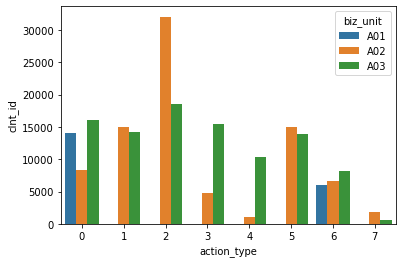

In [63]:
import seaborn as sns
sns.barplot(x='action_type', y='clnt_id', hue='biz_unit', data=temp)

- biz_unit에 따라 action_type 분포가 다르다<br>
    - A01: action_type=0, 6뿐 
    - A02: action_type=2 고객 많고 3, 4 고객 적음
    - A03: action_type이 거의 골고루 분포함
- action_type = 6 / action_type = 5 값이 기존 분석 결과에 비해서는 확연히 감소하였다 
    **--> 결제 시도를 2번 이상 한 사람을 1로 볼 것인지에 대해 다시 논의가 필요해 보임**

In [64]:
# biz_unit & dvc_ctg_nm 따른 uniqut clnt_id 갯수
temp = raw_data1_Online_Act.groupby(['biz_unit', 'dvc_ctg_nm'])[['clnt_id']].nunique()
temp.reset_index(inplace=True)
temp

,biz_unit,dvc_ctg_nm,clnt_id
0,A01,PC,3406
1,A01,mobile_app,4006
2,A01,mobile_web,9155
3,A02,PC,5756
4,A02,mobile_app,7532
5,A02,mobile_web,20324
6,A03,PC,3593
7,A03,mobile_web,9282


<AxesSubplot:xlabel='dvc_ctg_nm', ylabel='clnt_id'>

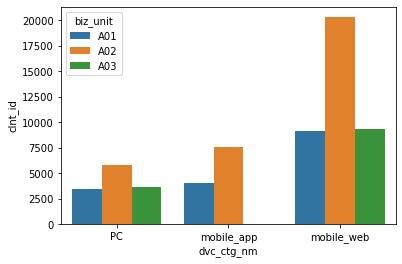

In [65]:
sns.barplot(x='dvc_ctg_nm', y='clnt_id', hue='biz_unit', data=temp)

- 모든 device에서 A02업종과 관련된 unique clnt_id 갯수가 많음
- 모든 업종에서 PC<mobile_app<mobile_web 순서로 unique clnt_id가 많아짐

<AxesSubplot:xlabel='biz_unit', ylabel='clnt_id'>

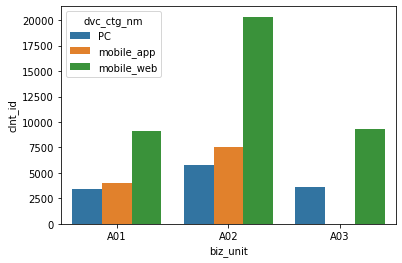

In [66]:
sns.barplot(x='biz_unit', y='clnt_id', hue='dvc_ctg_nm', data=temp)

- A02의 경우 mobile_web 사용 고객이 유난히 많음
- A03 업종은 mobile_app으로는 접근 불가한 업종임

**device나 biz_unit에서 발생하는 차이들은 '고객 특성'의 차이에서 오는 것으로 판단됩니다. 따라서 고객데이터를 사용한 EDA를 수행 해 볼 것을 제안합니다.**<br><br><br>

## 2. 거래 정보 데이터 확인

In [67]:
raw_data2_Trade_Inform.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,20190920,12:41,5990,1
1,21279,104907,4,A03,unknown,20190920,10:27,10900,1
2,39423,105124,11,A03,unknown,20190920,17:26,12900,1
3,18362,104010,1,A03,unknown,20190920,09:57,9900,1
4,39423,105124,13,A03,0565,20190920,17:26,2990,1


 * 2-1(=1-1, 3-1). clnt_id : 고객 고유 식별 ID
 * 2-2(=1-9). trans_ID : 거래 ID(구매내역을 고유 식별할 수 있는 ID)
 * 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호
 * 2-4(=1-5). biz_unit(업종단위) : 온라인 및 오프라인 이용코드
 * 2-5(=4-1). pd_c : 상품의 소분류 코드
 * 2-6. de_dt : 구매일자(년월일)
 * 2-7. de_tm : 구매시각(HHMM)
 * 2-8. buy_am : 구매금액
 * 2-9. buy_ct : 구매수량

In [68]:
raw_data2_Trade_Inform.shape

(599961, 9)

 * 행 수(데이터 갯수) : 59.9만 개
 * 열 수(데이터 종류) : 9개

### 2-1. clnt_id : 고객 고유 식별 ID

 * 1-1, 3-1 clnt_id와 동일 의미

 * 거래정보데이터 내 고객ID의 종류는 몇 개나 있는가?? => 11284개
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [69]:
raw_data2_Trade_Inform['clnt_id'].nunique()

11284

 * 고객ID 별 거래정보데이터는 몇 건이 있는지? => 최대 757건 , 최소 1건 

In [70]:
raw_data2_Trade_Inform['clnt_id'].value_counts()

27221    757
42575    681
52362    623
71243    579
12198    565
        ... 
32432      1
35025      1
27340      1
52443      1
14343      1
Name: clnt_id, Length: 11284, dtype: int64

 * 결측치 갯수 확인 => 없음

In [71]:
raw_data2_Trade_Inform['clnt_id'].isna().sum()

0

### 2-2. trans_id : 거래 ID(구매내역을 고유 식별할 수 있는 ID)

 * 1-9 trans_id와 동일 의미

 * 거래정보데이터 내 거래ID의 종류는 몇 개나 있는가?? => 11만개
     * 1. 온라인 행동 데이터 내 거래ID 갯수 : 50997개
     * 2. 거래 정보 데이터 내 거래ID 갯수 : 116440개

In [72]:
raw_data2_Trade_Inform['trans_id'].nunique()

116440

 * 거래ID 별 거래정보데이터는 몇 건이 있는지? => 최대 105건 , 최소 1건 

In [73]:
raw_data2_Trade_Inform['trans_id'].value_counts()

132554    105
51589     100
102723     72
132637     72
137451     65
         ... 
122815      1
4720        1
64109       1
114929      1
102596      1
Name: trans_id, Length: 116440, dtype: int64

 * 결측치 갯수 확인 => 없음

<br><br><br>
##### 우혜민 1-1) <br> Q) 온라인 행동 데이터 내 거래 ID와 거래 정보 데이터 내 거래 ID 갯수는 왜 차이가 날까???<br> A) Online_Act의 action_type에 따라 trans_id가 생성될 때도 있고 아닐 때도 있기 때문

거래정보데이터 내 거래ID의 종류는 몇 개나 있는가?? => 11만개<br>
온라인 행동 데이터 내 거래ID 갯수 : 50997개<br>
거래 정보 데이터 내 거래ID 갯수 : 116440개<br>

In [74]:
# 0) 분석 편의성 향상을 위해 clnt_id와 sess_id를 결합한 clnt_sess col 생성
raw_data1_Online_Act.insert(0, 'clnt_sess', raw_data1_Online_Act['clnt_id'].astype('str') + '_' + raw_data1_Online_Act['sess_id'].astype('str'))
raw_data1_Online_Act

,clnt_sess,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,day
0,7809_1,7809,1,8,5,A03,2019-09-13,01:16,2571103,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
1,7809_1,7809,1,4,2,A03,2019-09-13,01:14,2485909,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
2,7809_1,7809,1,11,5,A03,2019-09-13,01:17,2646597,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
3,7809_1,7809,1,1,2,A03,2019-09-13,00:46,788304,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
4,7809_1,7809,1,9,5,A03,2019-09-13,01:17,2617609,NaN,NaN,34.0,2663.0,DIRECT,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196357,31040_1,31040,1,1,0,A02,2019-08-15,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web,3
3196358,4129_1,4129,1,2,0,A02,2019-07-21,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web,6
3196359,4129_1,4129,1,1,0,A02,2019-07-21,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web,6
3196360,54403_3,54403,3,1,0,A02,2019-07-31,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app,2


In [75]:
# 1) trade info table에는 null이 없음
raw_data2_Trade_Inform['trans_id'].isna().sum()

0

In [76]:
# 2) Online Act table에는 null 많음
raw_data1_Online_Act.trans_id.isnull().sum()

3139373

In [77]:
# 3) raw_data2_Trade_Inform에는 buy_am, buy_ct라는 col이 있으며 둘 다 결측치 없음
print(raw_data2_Trade_Inform.buy_am.isnull().sum()) 
print(raw_data2_Trade_Inform.buy_ct.isnull().sum())

0
0


cf) action_type 의미<br>
0:검색 / 1:제품 목록 / 2:제품 세부정보 보기 / 3: 장바구니 제품 추가 / 4:장바구니 제품 삭제 / 5:결제 시도 / 6:구매완료 / 7:구매환불 / 8:결재 옵션

In [78]:
# 검색 ~ 결제시도까지의 과정에서는 trans_id가 생성되지 않음
np.sort(raw_data1_Online_Act[raw_data1_Online_Act.trans_id.isnull()].action_type.unique())

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [79]:
# action_type = 6, 7 (구매완료, 구매 환불)의 경우에만 trans_id가 생성됨
np.sort(raw_data1_Online_Act[raw_data1_Online_Act.trans_id.notnull()].action_type.unique())

array([6, 7], dtype=int64)

In [80]:
# 해당 데이터를 살펴보면 실제로 raw_data1_Online_Act 테이블에서 action_type=6, 7인 경우 trans_id에서 생성되고 있음을 확인 가능
raw_data1_Online_Act[(raw_data1_Online_Act['clnt_sess']=='52040_6')&
                    (raw_data1_Online_Act['action_type']==6)].sort_values(by='hit_seq')[:50]

,clnt_sess,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,day
2051188,52040_6,52040,6,1,6,A02,2019-08-14,08:27,253,75188.0,NaN,2.0,94.0,unknown,mobile_web,2
2051187,52040_6,52040,6,2,6,A02,2019-08-14,08:28,94136,NaN,NaN,2.0,94.0,unknown,mobile_web,2


<br><br><br>

### 2-3. trans_seq : 구매 내역 내 구매 순서를 알 수 있도록 한 일련번호

 * 거래정보데이터 내 구매일련번호의 종류는 몇 개나 있는가?? => 105개

In [81]:
raw_data2_Trade_Inform['trans_seq'].nunique()

105

 * 구매일련번호 별 거래정보데이터는 몇 건이 있는지? => 최대 11만건 , 최소 1건 

In [82]:
raw_data2_Trade_Inform['trans_seq'].value_counts()

1      116440
2       80693
3       66071
4       56049
5       48138
        ...  
102         1
103         1
104         1
101         1
105         1
Name: trans_seq, Length: 105, dtype: int64

 * 결측치 갯수 확인 => 없음

In [83]:
raw_data2_Trade_Inform['trans_seq'].isna().sum()

0

<br><br><br> 
##### HM) trans_id : '순서'의 개념 보다는 동일 trans_id 내에서 서로 다른 상품을 '구분'하는 역할
#### 즉, clnt_id, trans_id, trans_seq가 Trade_Inform table의 Primary Key가 됨

In [84]:
raw_data2_Trade_Inform[raw_data2_Trade_Inform.duplicated(['trans_id'])].sort_values(by='trans_id')[:50]

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
478521,47617,1,4,B01,1447,20190702,21:19,5490,1
478506,47617,1,8,B01,unknown,20190702,21:19,1800,3
478540,47617,1,6,B01,0388,20190702,21:19,10480,1
478503,47617,1,3,B01,0894,20190702,21:19,25900,1
478557,47617,1,7,B01,unknown,20190702,21:19,12000,1
478543,47617,1,5,B01,1529,20190702,21:19,5900,1
478560,47617,1,1,B01,0897,20190702,21:19,20640,3
478549,47617,2,7,B01,0894,20190702,21:20,17800,2
478517,47617,2,1,B01,1447,20190702,21:20,5990,1
478516,47617,2,5,B01,0894,20190702,21:20,16980,1


<br><br><br>

### 2-4. biz_unit(업종단위) : 온라인 및 오프라인 이용코드

 * 1-5. biz_unit 데이터와 의미 동일

 * 거래정보데이터 내 업종단위의 종류는 몇 개나 있는가?? => 6개
     * 1. 온라인 행동 데이터 내 업종단위 갯수 : 3개 (A01, A02, A03)
     * 2. 거래 정보 데이터 내 업종단위 갯수 : 6개 (A01, A02, A03, B01, B02, B03)

In [85]:
raw_data2_Trade_Inform['biz_unit'].nunique()

6

 * 업종단위 별 거래정보데이터는 몇 건이 있는지? => 최대 20만건 , 최소 3000건 

In [86]:
raw_data2_Trade_Inform['biz_unit'].value_counts()

A03    201982
B01    200781
B02    168803
A02     19850
A01      5126
B03      3419
Name: biz_unit, dtype: int64

 * 결측치 갯수 확인 => 없음

In [87]:
raw_data2_Trade_Inform['biz_unit'].isna().sum()

0

### 2-5. pd_c : 상품의 소분류 코드

 * 4-1. pd_c 데이터와 의미 동일

 * 거래정보데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1668개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [88]:
raw_data2_Trade_Inform['pd_c'].nunique()

1668

 * 소분류코드 별 거래정보데이터는 몇 건이 있는지? => 최대 1.5만건 , 최소 1건 

In [89]:
raw_data2_Trade_Inform['pd_c'].value_counts()

unknown    17652
1213       15518
0347       12914
0964       11115
1395       11083
           ...  
1336           1
1414           1
0655           1
1111           1
0746           1
Name: pd_c, Length: 1668, dtype: int64

 * 결측치 갯수 확인 => 17652개 (unknown)

### 2-6. de_dt : 구매일자(년월일)

 * 구매 일자는 몇 개나 있는가?? => 92개
     * 3달치 데이터가 날짜마다 있을 것을 예상됨
         * 7,8,9월 일자 = 31 + 31 + 30 = 92
         
 * 1. 온라인 행동 정보 데이터 내 '1-6. sess_dt 세션일자'와 연관 지을수 있음

In [90]:
raw_data2_Trade_Inform['de_dt'].nunique()

92

 * 구매일자 별 거래정보데이터는 몇 건이 있는지? => 최대 9357건 , 최소 1979건
     * 월별로 데이터 몇 개인지 확인해보기 => 추후 수행

In [91]:
raw_data2_Trade_Inform['de_dt'].value_counts()

20190911    9357
20190713    8707
20190720    8658
20190727    8603
20190921    8467
            ... 
20190922    3042
20190811    2806
20190728    2705
20190825    2462
20190913    1979
Name: de_dt, Length: 92, dtype: int64

 * 결측치 갯수 확인 => 없음

In [92]:
raw_data2_Trade_Inform['de_dt'].isna().sum()

0

### 2-7. de_tm : 구매시각(HHMM)

 * 구매 시각는 몇 개나 있는가?? => 1436개

In [93]:
raw_data2_Trade_Inform['de_tm'].nunique()

1436

 * 구매시각 거래정보데이터는 몇 건이 있는지? => 최대 1094건 , 최소 1건
 * 1-7 조회 시각 데이터와 연관지어볼 수 있음 => 추후 분석

In [94]:
raw_data2_Trade_Inform['de_tm'].value_counts()

16:17    1094
18:03    1033
17:11    1012
17:27     992
17:18     985
         ... 
03:37       1
04:31       1
05:26       1
05:00       1
06:07       1
Name: de_tm, Length: 1436, dtype: int64

 * 결측치 갯수 확인 => 없음

In [95]:
raw_data2_Trade_Inform['de_tm'].isna().sum()

0

### 2-8. buy_am : 구매금액

 * 구매 금액은 몇 개나 있는가?? => 14810개

In [96]:
raw_data2_Trade_Inform['buy_am'].nunique()

14810

 * 구매금액 별 거래정보데이터는 몇 건이 있는지? => 최대 1.8만건 , 최소 1건

In [97]:
raw_data2_Trade_Inform['buy_am'].value_counts()

2990      18064
1000      16200
1990      15745
3990      14652
990       14087
          ...  
969000        1
150200        1
113350        1
39650         1
4094          1
Name: buy_am, Length: 14810, dtype: int64

 * 결측치 갯수 확인 => 최소 금액 0을 결측치로 봐야할지 공짜로 봐야할지 추후 고려

In [98]:
raw_data2_Trade_Inform['buy_am'].isna().sum()

0

 * 최대 금액은?? => 1천억

In [99]:
max(raw_data2_Trade_Inform['buy_am'])

100000016899

 * 최소금액은?? => 0
     * 공짜로 봐야할 지, 결측치로 봐야할 지 추후 고려

In [100]:
min(raw_data2_Trade_Inform['buy_am'])

0

### 2-9. buy_ct : 구매 수량

 * 구매수량은 몇 종류나 있는가?? => 338개

In [101]:
raw_data2_Trade_Inform['buy_ct'].nunique()

338

 * 구매수량 별 거래정보데이터는 몇 건이 있는지? => 최대 49만건 , 최소 1건

In [102]:
raw_data2_Trade_Inform['buy_ct'].value_counts()

1      497831
2       62837
3       12371
0        6775
4        6377
        ...  
210         1
207         1
717         1
204         1
155         1
Name: buy_ct, Length: 338, dtype: int64

 * NaN 갯수 확인 => 없음
     * 위 최소 수량 0을 결측치로 고려 => 6775개

In [103]:
raw_data2_Trade_Inform['buy_ct'].isna().sum()

0

 * 최대 수량은?? => 3600개

In [104]:
max(raw_data2_Trade_Inform['buy_ct'])

3600

 * 최소 수량은?? => 0
     * 결측치로 고려

In [105]:
min(raw_data2_Trade_Inform['buy_ct'])

0

<br><br><br>
##### 우혜민 1-2) 고객군별 구입 상품 분포가 다름

In [9]:
# merge를 위한 자료형 통일
raw_data2_Trade_Inform.loc[raw_data2_Trade_Inform['pd_c']=='unknown', 'pd_c']=np.nan
raw_data2_Trade_Inform.pd_c = raw_data2_Trade_Inform.pd_c.astype('float64')

In [10]:
# trans_id가 있는 고객들의 (trans_id, pd_c)별 (buy_am, buy_ct)
t1 = pd.merge(raw_data1_Online_Act.loc[raw_data1_Online_Act.trans_id.notnull(),
                             ['clnt_id', 'trans_id', 'biz_unit']],
             raw_data2_Trade_Inform[['trans_id', 'pd_c', 'buy_am', 'buy_ct']],
             how='left', on='trans_id')
t1.head()

,clnt_id,trans_id,biz_unit,pd_c,buy_am,buy_ct
0,2,62037.0,A03,92.0,36000.0,20.0
1,2,64691.0,A03,186.0,3790.0,1.0
2,2,64691.0,A03,151.0,3990.0,1.0
3,2,64691.0,A03,351.0,4690.0,1.0
4,2,64691.0,A03,189.0,4290.0,1.0


In [11]:
t2 = pd.merge(t1[(t1['pd_c'].notnull())],
               raw_data3_Demog,
               how='left', on='clnt_id')
t2.head()

,clnt_id,trans_id,biz_unit,pd_c,buy_am,buy_ct,clnt_gender,clnt_age
0,2,62037.0,A03,92.0,36000.0,20.0,F,30.0
1,2,64691.0,A03,186.0,3790.0,1.0,F,30.0
2,2,64691.0,A03,151.0,3990.0,1.0,F,30.0
3,2,64691.0,A03,351.0,4690.0,1.0,F,30.0
4,2,64691.0,A03,189.0,4290.0,1.0,F,30.0


In [109]:
t2.buy_ct.unique()

array([  1.,   3.,   2.,   4.,   5.,  12.,  10.,   8.,   7.,   6.,  14.,
        15.,  20.,   9.,  30.,  11.,   0.,  28.,  25.,  13.,  18.,  19.,
       500.,  16.,  40.,  17.,  24.,  22.,  21.,  48.,  29.,  41.,  35.])

In [12]:
temp = pd.merge(t2, 
               raw_data4_Item_Class[['pd_c', 'clac_nm0', 'clac_nm1']],
               how='left', on='pd_c')
temp

,clnt_id,trans_id,biz_unit,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm0,clac_nm1
0,2,62037.0,A03,92.0,36000.0,20.0,F,30.0,Food,Beverages
1,2,64691.0,A03,186.0,3790.0,1.0,F,30.0,Food,Chilled Foods
2,2,64691.0,A03,151.0,3990.0,1.0,F,30.0,Food,Canned / Jarred Foods
3,2,64691.0,A03,351.0,4690.0,1.0,F,30.0,Food,Dairy Products
4,2,64691.0,A03,189.0,4290.0,1.0,F,30.0,Food,Chilled Foods
...,...,...,...,...,...,...,...,...,...,...
38424,25504,65354.0,A03,1623.0,1990.0,1.0,F,30.0,Food,Vegetables
38425,25504,65354.0,A03,1194.0,1000.0,1.0,F,30.0,Food,Snack Foods
38426,25504,65354.0,A03,1394.0,3960.0,2.0,F,30.0,Food,Substitute Foods
38427,25505,65291.0,A03,670.0,55400.0,1.0,F,30.0,Food,Grains


In [13]:
#biz_unit X action_type에 따른 uniqut clnt_id 갯수
temp = temp.groupby(['clnt_gender', 'clnt_age', 'biz_unit', 'clac_nm0', 'clac_nm1'])[['buy_ct']].count()
temp.reset_index(inplace=True)
temp

,clnt_gender,clnt_age,biz_unit,clac_nm0,clac_nm1,buy_ct
0,F,10.0,A01,Baby,Automotive Products,NaN
1,F,10.0,A01,Baby,Baby Foods,NaN
2,F,10.0,A01,Baby,Ball Game / Field Sports,NaN
3,F,10.0,A01,Baby,Bedding / Handicraft,NaN
4,F,10.0,A01,Baby,Beverages,NaN
...,...,...,...,...,...,...
20155,M,60.0,A03,Travel,Travel / Leisure Services,NaN
20156,M,60.0,A03,Travel,Underwear / Socks and Hosiery / Homewear,NaN
20157,M,60.0,A03,Travel,Vegetables,NaN
20158,M,60.0,A03,Travel,Video / Audio System Electronics,NaN


In [15]:
temp['clnt_age'] = temp['clnt_age'].astype(str)

In [16]:
# clnt_gender, clnt_age에 따라 고객군을 분류하는 col (gen_age) 생성
temp['gen_age'] = temp['clnt_gender'].str.cat(temp['clnt_age'],sep="_")
temp.head()

,clnt_gender,clnt_age,biz_unit,clac_nm0,clac_nm1,buy_ct,gen_age
0,F,10.0,A01,Baby,Automotive Products,NaN,F_10.0
1,F,10.0,A01,Baby,Baby Foods,NaN,F_10.0
2,F,10.0,A01,Baby,Ball Game / Field Sports,NaN,F_10.0
3,F,10.0,A01,Baby,Bedding / Handicraft,NaN,F_10.0
4,F,10.0,A01,Baby,Beverages,NaN,F_10.0


In [17]:
temp.biz_unit = temp.biz_unit.astype('category')

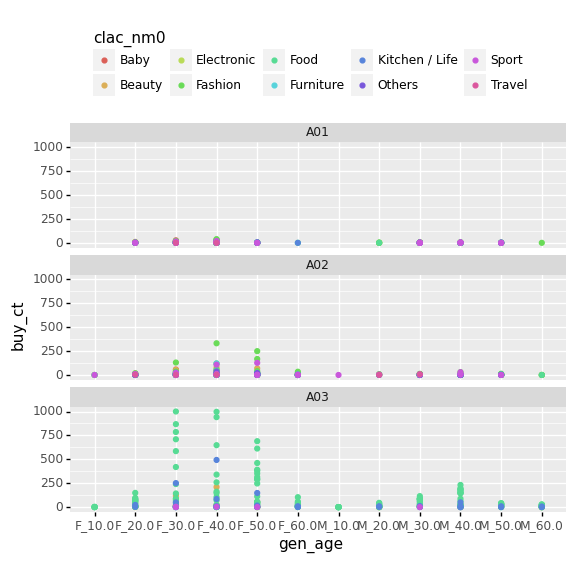

<ggplot: (8728438398537)>

In [22]:
ggplot(data = temp, mapping = aes(x='gen_age', y='buy_ct', color='clac_nm0')) +\
geom_point() +\
facet_wrap("biz_unit", nrow=3)+\
theme(legend_position = "top") +\
ylim((0, 1000))

 ## 3. 사용자 demo 정보(나이, 성별) 확인

In [185]:
raw_data3_Demog.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


 * 3-1(=2-1, 1-1). clnt_id : 고객 고유 식별 ID
 * 3-2. clnt_gender : 고객 성별
 * 3-3. clnt_age : 고객 연령대( 10단위:  10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown)

In [186]:
raw_data3_Demog.shape

(72399, 3)

 * 행 수(데이터 갯수) : 7.2만 개
 * 열 수(데이터 종류) : 3개

### 3-1. clnt_Id : 고객 고유 식별 ID

 * 1-1, 2-1 clnt_id와 동일 의미

 * 고객 ID는 몇 개나 있는가?? => 7만명의 고객 ID 보유
     * 1. 온라인 행동 데이터 내 고객ID 갯수 : 72399개
     * 2. 거래 정보 데이터 내 고객ID 갯수 :11284개
     * 3. 사용자 demog 정보 내 고객ID 갯수 : 72399개

In [187]:
raw_data3_Demog['clnt_id'].nunique()

72399

 * 고객ID 별로 사용자 demog 데이터는 몇 건이 있는지? => 1건
     * 서로 다른 사람이 같은 ID를 공유하는 오류데이터는 없음

In [188]:
raw_data3_Demog['clnt_id'].value_counts()

2047     1
27288    1
14994    1
12947    1
2708     1
        ..
25958    1
32101    1
30052    1
19811    1
2049     1
Name: clnt_id, Length: 72399, dtype: int64

 * 결측치 갯수 확인 => 없음

In [189]:
raw_data3_Demog['clnt_id'].isna().sum()

0

### 3-2. clnt_gender : 고객 성별

 * 성별은 몇 개나 있는가?? => 3개 (남, 여, 알수 없음)

In [190]:
raw_data3_Demog['clnt_gender'].nunique()

3

 * 성별 별로 사용자 demog 데이터는 몇 건이 있는지? => 알 수없음 6만, 여성 1만, 남성 1800

In [191]:
raw_data3_Demog['clnt_gender'].value_counts()

unknown    60154
F          10352
M           1893
Name: clnt_gender, dtype: int64

 * 결측치 갯수 확인 => 60154개

### 3-3. clnt_age : 고객 연령대

 * 10단위: 10대 이하 / 20대 / 30대 / 40대 / 50대 / 60대 / unknown

 * 연령대는 몇 종류나 있는가?? => 7종

In [192]:
raw_data3_Demog['clnt_age'].nunique()

7

 * 연령 별로 사용자 demog 데이터는 몇 건이 있는지?
 
     * 10대 : 46
     * 20대 : 924
     * 30대 : 4307
     * 40대 : 4948
     * 50대 : 1694
     * 60대 : 326
     * 알 수 없음 : 60154

In [193]:
raw_data3_Demog['clnt_age'].value_counts()

unknown    60154
40          4948
30          4307
50          1694
20           924
60           326
10            46
Name: clnt_age, dtype: int64

 * 결측치 갯수 확인 => 60154개

## 4. 상품 대중소 분류 정보

In [194]:
raw_data4_Item_Class.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


* 4-1. pd_c : 상품 소분류 코드
* 4-2. clac_nm1 : 상품 대분류명
* 4-3. clac_nm2 : 상품 중분류명
* 4-4. clac_nm3 : 상품 소분류명

In [195]:
raw_data4_Item_Class.shape

(1667, 4)

 * 행 수(데이터 갯수) : 1667개
 * 열 수(데이터 종류) : 4개

### 4-1. pd_c : 상품의 소분류 코드

 * 2-5. pd_c 데이터와 의미 동일

 * 상품분류데이터 내 소분류 코드의 종류는 몇 개나 있는가?? => 1667개
     * 2. 거래 정보 데이터 내 소분류 갯수 : 1668개
     * 4. 상품 대중소 분류 데이터 내 소분류 갯수 : 1667개
     * 1개 차이는 'unknown' 유무로 예상

In [196]:
raw_data4_Item_Class['pd_c'].nunique()

1667

 * 소분류코드 별 상품분류데이터는 몇 건이 있는지? => 각 1건

In [197]:
raw_data4_Item_Class['pd_c'].value_counts()

1667    1
834     1
1098    1
1100    1
1102    1
       ..
563     1
565     1
567     1
569     1
2       1
Name: pd_c, Length: 1667, dtype: int64

 * 결측치 갯수 확인 => 없음

In [198]:
raw_data4_Item_Class['pd_c'].isna().sum()

0

### 4-2. clac_nm1 : 상품 대분류명

 * 상품분류데이터 내 대분류명의 종류는 몇 개나 있는가?? => 60개

In [199]:
raw_data4_Item_Class['clac_nm1'].nunique()

60

 * 대분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 100건, 최소 1건

In [200]:
raw_data4_Item_Class['clac_nm1'].value_counts()

Fashion Accessories                          100
Meats                                         80
Sea Foods                                     76
Vegetables                                    70
Kids' Clothing                                67
Stationary / Office Supplies                  61
Fruits                                        56
Underwear / Socks and Hosiery / Homewear      53
Sport Fashion                                 52
Spices / Seasonings                           49
Cosmetics / Beauty Care                       48
Personal Care                                 38
Snack Foods                                   36
Cooked Foods                                  35
Gardening / Pets                              35
Tableware / Cooking Utensils                  35
Home / Kitchen Appliances                     33
Chilled Foods                                 32
Bedding / Handicraft                          30
Cleaning / Laundry / Bathroom Accessories     30
Kitchenware         

 * 결측치 갯수 확인 => 없음

In [201]:
raw_data4_Item_Class['clac_nm1'].isna().sum()

0

### 4-3. clac_nm2 : 상품 중분류명

 * 상품분류데이터 내 중분류명의 종류는 몇 개나 있는가?? => 332개

In [202]:
raw_data4_Item_Class['clac_nm2'].nunique()

332

 * 중분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 19건, 최소 1건

In [203]:
raw_data4_Item_Class['clac_nm2'].value_counts()

Fish                                    19
Kitchen Appliances                      17
Domestic Fruits                         16
Leaf Vegetables                         16
Imported Fruits                         16
                                        ..
Installation-Service / DIY Furniture     1
Fixed-price General Merchandise          1
Ready to Drinks                          1
Gift Certificates                        1
Other Furniture                          1
Name: clac_nm2, Length: 332, dtype: int64

 * 결측치 갯수 확인 => 없음

In [204]:
raw_data4_Item_Class['clac_nm2'].isna().sum()

0

### 4-4. clac_nm3 : 상품 소분류명

 * 상품분류데이터 내 소분류명의 종류는 몇 개나 있는가?? => 1662개
     * 4-1. 소분류코드 종류 갯수 : 1667개
     * 1662 + 3(같은이름 다른코드) + 2(결측치) = 1667

In [205]:
raw_data4_Item_Class['clac_nm3'].nunique()

1662

 * 소분류명 별 상품분류데이터는 몇 건이 있는지? => 최대 2건, 최소 1건
     * 같은 상품 이름에 서로다른 소분류 코드 존재(Salads, Peppers, Lunch Boxes)

In [206]:
raw_data4_Item_Class['clac_nm3'].value_counts()

Peppers                                    2
Lunch Boxes                                2
Salads                                     2
Collection Dolls                           1
Sewing Boxes                               1
                                          ..
Health Masks                               1
Plaice                                     1
Peaches                                    1
Other Vacuum Cleaners                      1
Pet Cat Shower Accessories / Care Goods    1
Name: clac_nm3, Length: 1662, dtype: int64

 * 결측치 갯수 확인 => 2개

In [207]:
raw_data4_Item_Class['clac_nm3'].isna().sum()

2

* 시각화 예시 - 막대 그래프

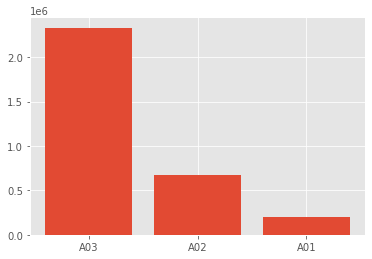

In [208]:
plt.style.use('ggplot')

fig = plt.figure()

ax = fig.add_subplot()
ax.bar(raw_data1_Online_Act['biz_unit'].unique(), raw_data1_Online_Act['biz_unit'].value_counts())

plt.show()